Read in halo/stellar mass catalog from TreePM256 simulation, and generate mock survey data sets corresponding to that used in the CLAMATO2017 cross-correlation.

In [3]:
import numpy as np
import time as time
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

def read_fofp_file(path):
    """
    Read FoF properties file from the give path.
    Just returns a tuple of masses and positions for now, but can be modified
    easily.
    Note that positions are in box size units.

    """
    # get file handle
    fof_file = open(path, "r")

    # use fromfile to read binary chunks
    # number of halos
    num_groups = np.asscalar(np.fromfile(fof_file, dtype="i4", count=1))
    print("{} halos read".format(num_groups))
    # the mass in Msun/h
    masses = np.fromfile(fof_file, dtype="f4", count=num_groups)
    sigma = np.fromfile(fof_file, dtype="f4", count=num_groups)
    v_circ = np.fromfile(fof_file, dtype="f4", count=num_groups)
    min_id = np.fromfile(fof_file, dtype="f4", count=num_groups)
    v_pot_e = np.fromfile(fof_file, dtype="f4", count=num_groups)
    positions = np.fromfile(fof_file, dtype="f4", count=3*num_groups)

    # done reading
    fof_file.close()

    # correct the shape
    positions.shape = (num_groups, 3)

    return (masses, positions)

# Define methods that select galaxies within map boundaries for each survey. 
# Need to be able to handle period boundary conditions


7817171 halos read


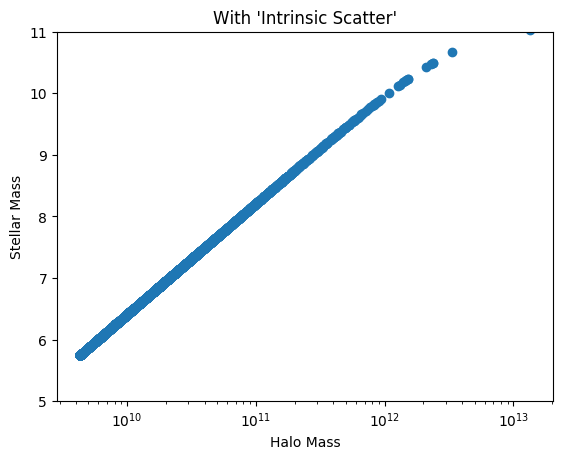

In [4]:
fofp_path = 'treepm_stellar_masses/halos_z25.fofp'
smass_path = 'treepm_stellar_masses/sm_moster.bin'

masses, positions = read_fofp_file(fofp_path)

smass_file = open(smass_path, "r")

smass = np.fromfile(smass_file, dtype=masses.dtype, count=len(masses))

smass_file.close()

fig, ax = plt.subplots()

subind = np.arange(len(smass))
subind = np.random.choice(subind, 8000, replace='False')

ax.scatter(masses[subind], smass[subind])
ax.set_xscale("log", nonposx='clip')
ax.set_ylim([5,11])
ax.set_title("With 'Intrinsic Scatter'")
ax.set_xlabel("Halo Mass")
ax.set_ylabel("Stellar Mass")

plt.show()


[ 7.   7.2  7.4  7.6  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6
  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4
 12.6]


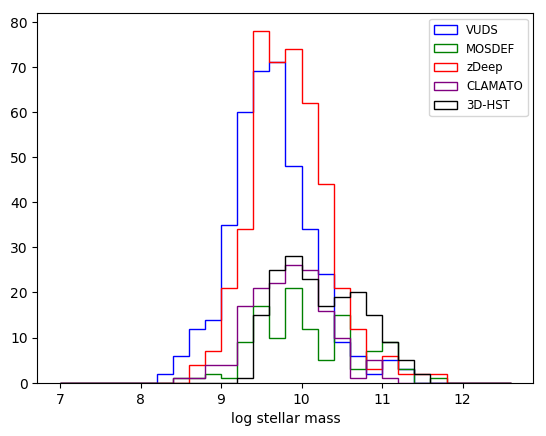

1 NaNs from MOSDEF galaxies
9 NaNs from VUDS galaxies
2 NaNs from zDeep galaxies
0 NaNs from CLAMATO galaxies
1 NaNs from 3D-HST galaxies
Median M_star = 9.961423545667541 for MOSDEF
Median M_star = 9.607491969644045 for VUDS
Median M_star = 9.811885948985875 for zDeep
Median M_star = 9.838085022131871 for CLAMATO
Median M_star = 10.169682885752684 for 3D-HST
<M_star> = 10.072709579352148 for MOSDEF
<M_star> = 9.631830942127538 for VUDS
<M_star> = 9.850837410470994 for zDeep
<M_star> = 9.849167003079868 for CLAMATO
<M_star> = 10.254219354916286 for 3D-HST


In [7]:
gal_cat_fil = 'CLAMATO_2017_Cross-correlation_catalog_w_Mstar.txt'

galcat = ascii.read(gal_cat_fil)

get_mosdef = np.squeeze(np.where(galcat['source'].data == 'MOSDEF'))
get_vuds = np.squeeze(np.where(galcat['source'].data == 'VUDS'))
get_clamato = np.squeeze(np.where(galcat['source'].data == 'CLAMATO'))
get_zdeep = np.squeeze(np.where(galcat['source'].data == 'zDeep'))
get_3dhst = np.squeeze(np.where(galcat['source'].data == '3DHST'))

mstars = galcat['mstar'].data

mstars_mosdef = np.log10(mstars[get_mosdef])
mstars_vuds = np.log10(mstars[get_vuds])
mstars_clamato = np.log10(mstars[get_clamato])
mstars_zdeep = np.log10(mstars[get_zdeep])
mstars_3dhst = np.log10(mstars[get_3dhst])

# limits for the histogram bins
min_mstar = 7.
max_mstar = 12.6

fig, ax = plt.subplots()
binsize=0.2

histbins = np.arange(min_mstar,max_mstar+binsize, binsize)
print(histbins)

ax.hist(mstars_vuds[~np.isnan(mstars_vuds)], bins=histbins, histtype='step',fill=False, 
        color='blue',label='VUDS')
ax.hist(mstars_mosdef[~np.isnan(mstars_mosdef)], bins = histbins, histtype='step', fill=False,
        color='green',label='MOSDEF')
ax.hist(mstars_zdeep[~np.isnan(mstars_zdeep)], bins = histbins, histtype='step', fill=False,
        color='red', label='zDeep')
ax.hist(mstars_clamato[~np.isnan(mstars_clamato)], bins = histbins, histtype='step', fill=False,
        color='purple', label='CLAMATO')
ax.hist(mstars_3dhst[~np.isnan(mstars_3dhst)], bins = histbins, histtype='step', fill=False,
        color='black', label='3D-HST')

ax.set_xlabel('log stellar mass')

plt.legend(fontsize='small')
plt.show()

print('{} NaNs from MOSDEF galaxies'.format(np.sum(np.isnan(mstars_mosdef))))
print('{} NaNs from VUDS galaxies'.format(np.sum(np.isnan(mstars_vuds))))
print('{} NaNs from zDeep galaxies'.format(np.sum(np.isnan(mstars_zdeep))))
print('{} NaNs from CLAMATO galaxies'.format(np.sum(np.isnan(mstars_clamato))))
print('{} NaNs from 3D-HST galaxies'.format(np.sum(np.isnan(mstars_3dhst))))

print('Median M_star = {} for MOSDEF'.format(np.median(mstars_mosdef[~np.isnan(mstars_mosdef)])))
print('Median M_star = {} for VUDS'.format(np.median(mstars_vuds[~np.isnan(mstars_vuds)])))
print('Median M_star = {} for zDeep'.format(np.median(mstars_zdeep[~np.isnan(mstars_zdeep)])))
print('Median M_star = {} for CLAMATO'.format(np.median(mstars_clamato[~np.isnan(mstars_clamato)])))
print('Median M_star = {} for 3D-HST'.format(np.median(mstars_3dhst[~np.isnan(mstars_3dhst)])))

print('<M_star> = {} for MOSDEF'.format(np.mean(mstars_mosdef[~np.isnan(mstars_mosdef)])))
print('<M_star> = {} for VUDS'.format(np.mean(mstars_vuds[~np.isnan(mstars_vuds)])))
print('<M_star> = {} for zDeep'.format(np.mean(mstars_zdeep[~np.isnan(mstars_zdeep)])))
print('<M_star> = {} for CLAMATO'.format(np.mean(mstars_clamato[~np.isnan(mstars_clamato)])))
print('<M_star> = {} for 3D-HST'.format(np.mean(mstars_3dhst[~np.isnan(mstars_3dhst)])))

# Calculate the histograms for later use
hist_mosdef = np.histogram(mstars_mosdef[~np.isnan(mstars_mosdef)], bins=histbins, density=False)
hist_vuds   = np.histogram(mstars_vuds[~np.isnan(mstars_vuds)], bins=histbins, density=False)
hist_zdeep   = np.histogram(mstars_zdeep[~np.isnan(mstars_zdeep)], bins=histbins, density=False)
hist_clamato   = np.histogram(mstars_clamato[~np.isnan(mstars_clamato)], bins=histbins, density=False)
hist_3dhst   = np.histogram(mstars_3dhst[~np.isnan(mstars_3dhst)], bins=histbins, density=False)

In [ ]:
# Generate mock redshift catalogs

# We will create mocks over these number of distinct fields
nmock_x = 8
nmock_y = 10
nmocks = nmock_x * nmock_y

width_x = 30. # Mpc/h
width_y = 24. # Mpc/h

# Generate lists indicating the CLAMATO field boundaries and centers
xlow_field = np.arange(nmock_x)*width_x
xhi_field = (np.arange(nmock_x) + 1.)*width_x 
xcen_field = np.ndarray.tolist((xlow_field+xhi_field)/2.)

ylow_field = np.arange(nmock_y) * width_y
yhi_field  = (np.arange(nmock_y)+1.)* width_y
ycen_field = np.ndarray.tolist((ylow_field+yhi_field)/2.)



